In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-12 00:13:09.525341: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-12 00:13:10.671372: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-12 00:13:10.714627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 00:13:10.714681: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 00:13:10.719059: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-12 00:13:10.719120: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-12 00:13:10.720928: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

ukdale_gen_GASF_13m_100S5X12A54480_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.46362011743681386, 1: 0.6056361514090378, 2: 1.5133333333333334, 3: 1.2690426275331936, 4: 1.0880766926303176, 5: 1.3567426223384385, 6: 0.9253503184713375, 7: 1.5133333333333334, 8: 0.8680688336520076, 9: 2.2857142857142856, 10: 0.8724477540235407, 11: 1.6397291196388262}
 
Tests 
HEKA test: 1959 train: 7834
fridge/freezer test: 1499 train: 5997
HTPC test: 600 train: 2400
boiler test: 715 train: 2862
computer monitor test: 835 train: 3338
desktop computer test: 669 train: 2677
laptop computer test: 981 train: 3925
light test: 600 train: 2400
microwave test: 1046 train: 4184
server computer test: 397 train: 1589
television test: 1041 train: 4163
washer dryer test: 554 train: 2215


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/ukdale/TL/ukdale_12_refit, iawe, eco, redd_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data ukdale training on model refit seed 12
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.46362011743681386, 1: 0.6056361514090378, 2: 1.5133333333333334, 3: 1.2690426275331936, 4: 1.0880766926303176, 5: 1.3567426223384385, 6: 0.9253503184713375, 7: 1.5133333333333334, 8: 0.8680688336520076, 9: 2.2857142857142856, 10: 0.8724477540235407, 11: 1.6397291196388262}
 
Tests 
HEKA test: 1959 train: 7834
fridge/freezer test: 1499 train: 5997
HTPC test: 600 train: 2400
boiler test: 715 train: 2862
computer monitor test: 835 train: 3338
desktop computer test: 669 train: 2677
laptop computer test: 981 train: 3925
light test: 600 train: 2400
microwave test: 1046 train: 4184
server computer test: 397 train: 1589
television test: 1041 train: 4163
washer dryer test: 554 train: 2215
loading model
compling TL model..


2022-02-12 00:13:13.915899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 00:13:13.916382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-12 00:13:13.916440: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 00:13:14.280028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-12 00:13:14.280062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-12 00:13:14.280068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-12 00:13:14.280674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-12 00:13:22.058646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-12 00:13:22.076598: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-12 00:13:25.546962: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-12 00:13:26.299746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-12 00:13:27.145390: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-12 00:13:27.565294: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1362/1362 - 32s - loss: 0.6803 - accuracy: 0.7559
Epoch 2/50
1362/1362 - 32s - loss: 0.5169 - accuracy: 0.8100
Epoch 3/50
1362/1362 - 33s - loss: 0.4907 - accuracy: 0.8183
Epoch 4/50
1362/1362 - 33s - loss: 0.4736 - accuracy: 0.8231
Epoch 5/50
1362/1362 - 33s - loss: 0.4642 - accuracy: 0.8262
Epoch 6/50
1362/1362 - 33s - loss: 0.4526 - accuracy: 0.8289
Epoch 7/50
1362/1362 - 33s - loss: 0.4473 - accuracy: 0.8319
Epoch 8/50
1362/1362 - 32s - loss: 0.4444 - accuracy: 0.8324
Epoch 9/50
1362/1362 - 33s - loss: 0.4342 - accuracy: 0.8345
Epoch 10/50
1362/1362 - 33s - loss: 0.4327 - accuracy: 0.8353
Epoch 11/50
1362/1362 - 32s - loss: 0.4321 - accuracy: 0.8359
Epoch 12/50
1362/1362 - 32s - loss: 0.4238 - accuracy: 0.8383
Epoch 13/50
1362/1362 - 32s - loss: 0.4222 - accuracy: 0.8357
Epoch 14/50
1362/1362 - 33s - loss: 0.4187 - accuracy: 0.8394
Epoch 15/50
1362/1362 - 33s - loss: 0.4157 - accuracy: 0.8409
Epoch 16/50
1362/1362 - 33s - loss: 0.4134 - accuracy: 0.8425
Epoch 17/50
1362/1362 - 32s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
1362/1362 - 30s - loss: 1.2178 - accuracy: 0.5910
Epoch 2/50
1362/1362 - 31s - loss: 1.0110 - accuracy: 0.6556
Epoch 3/50
1362/1362 - 32s - loss: 0.9650 - accuracy: 0.6719
Epoch 4/50
1362/1362 - 32s - loss: 0.9472 - accuracy: 0.6804
Epoch 5/50
1362/1362 - 32s - loss: 0.9264 - accuracy: 0.6851
Epoch 6/50
1362/1362 - 33s - loss: 0.9108 - accuracy: 0.6942
Epoch 7/50
1362/1362 - 33s - loss: 0.9013 - accuracy: 0.6965
Epoch 8/50
1362/1362 - 33s - loss: 0.8930 - accuracy: 0.6971
Epoch 9/50
1362/1362 - 32s - loss: 0.8863 - accuracy: 0.6992
Epoch 10/50
1362/1362 - 33s - loss: 0.8816 - accuracy: 0.7015
Epoch 11/50
1362/1362 - 32s - loss: 0.8685 - accuracy: 0.7045
Epoch 12/50
1362/1362 - 32s - loss: 0.8625 - accuracy: 0.7055
Epoch 13/50
1362/1362 - 32s - loss: 0.8590 - accuracy: 0.7088
Epoch 14/50
1362/1362 - 32s - loss: 0.8573 - accuracy: 0.7085
Epoch 15/50
1362/1362 - 32s - loss: 0.8555 - accuracy: 0.7082
Epoch 16/50
1362/1362 - 32s - loss: 0.8465 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
1362/1362 - 30s - loss: 0.9967 - accuracy: 0.6512
Epoch 2/50
1362/1362 - 33s - loss: 0.7706 - accuracy: 0.7182
Epoch 3/50
1362/1362 - 32s - loss: 0.7319 - accuracy: 0.7327
Epoch 4/50
1362/1362 - 31s - loss: 0.7116 - accuracy: 0.7416
Epoch 5/50
1362/1362 - 32s - loss: 0.6992 - accuracy: 0.7429
Epoch 6/50
1362/1362 - 33s - loss: 0.6898 - accuracy: 0.7464
Epoch 7/50
1362/1362 - 31s - loss: 0.6773 - accuracy: 0.7507
Epoch 8/50
1362/1362 - 33s - loss: 0.6673 - accuracy: 0.7537
Epoch 9/50
1362/1362 - 33s - loss: 0.6712 - accuracy: 0.7511
Epoch 10/50
1362/1362 - 31s - loss: 0.6603 - accuracy: 0.7583
Epoch 11/50
1362/1362 - 33s - loss: 0.6504 - accuracy: 0.7583
Epoch 12/50
1362/1362 - 32s - loss: 0.6552 - accuracy: 0.7610
Epoch 13/50
1362/1362 - 33s - loss: 0.6459 - accuracy: 0.7638
Epoch 14/50
1362/1362 - 32s - loss: 0.6438 - accuracy: 0.7605
Epoch 15/50
1362/1362 - 32s - loss: 0.6401 - accuracy: 0.7630
Epoch 16/50
1362/1362 - 32s - loss: 0.6373 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
1362/1362 - 30s - loss: 1.0124 - accuracy: 0.6331
Epoch 2/50
1362/1362 - 33s - loss: 0.8318 - accuracy: 0.6935
Epoch 3/50
1362/1362 - 33s - loss: 0.7939 - accuracy: 0.7007
Epoch 4/50
1362/1362 - 33s - loss: 0.7741 - accuracy: 0.7117
Epoch 5/50
1362/1362 - 32s - loss: 0.7518 - accuracy: 0.7162
Epoch 6/50
1362/1362 - 33s - loss: 0.7405 - accuracy: 0.7190
Epoch 7/50
1362/1362 - 32s - loss: 0.7311 - accuracy: 0.7236
Epoch 8/50
1362/1362 - 33s - loss: 0.7306 - accuracy: 0.7233
Epoch 9/50
1362/1362 - 33s - loss: 0.7215 - accuracy: 0.7238
Epoch 10/50
1362/1362 - 31s - loss: 0.7112 - accuracy: 0.7273
Epoch 11/50
1362/1362 - 33s - loss: 0.7083 - accuracy: 0.7275
Epoch 12/50
1362/1362 - 33s - loss: 0.7007 - accuracy: 0.7326
Epoch 13/50
1362/1362 - 33s - loss: 0.6961 - accuracy: 0.7316
Epoch 14/50
1362/1362 - 33s - loss: 0.6982 - accuracy: 0.7345
Epoch 15/50
1362/1362 - 32s - loss: 0.6906 - accuracy: 0.7375
Epoch 16/50
1362/1362 - 33s - loss: 0.6875 - a

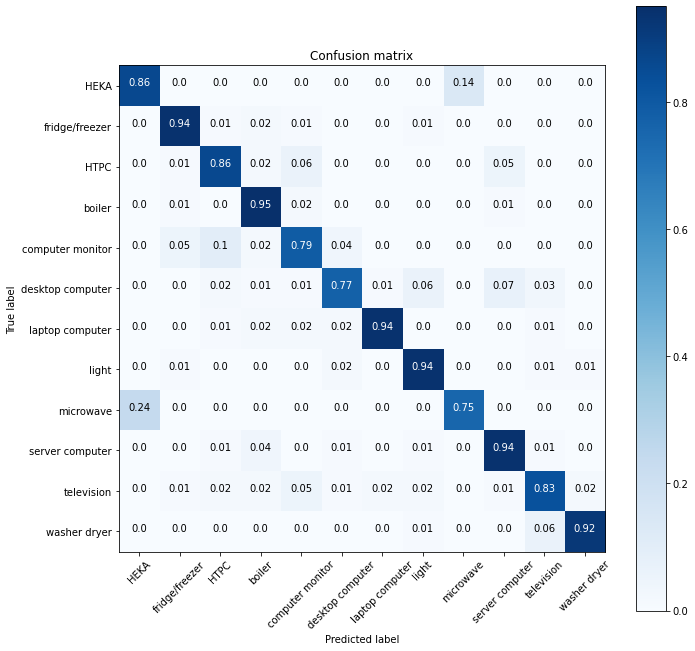

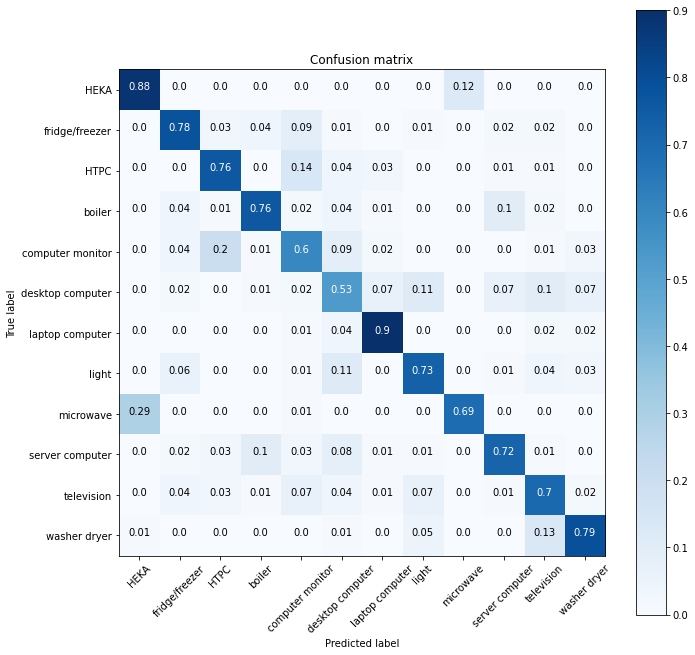

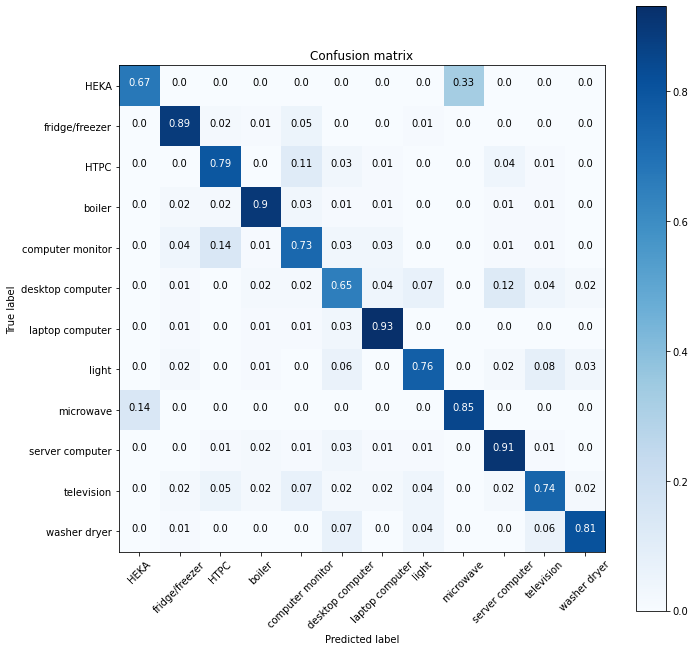

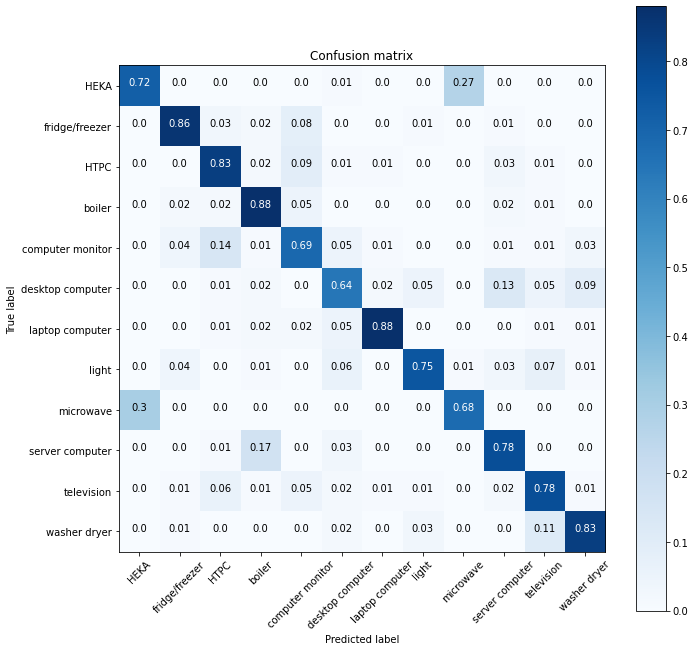

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()